In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
%matplotlib inline

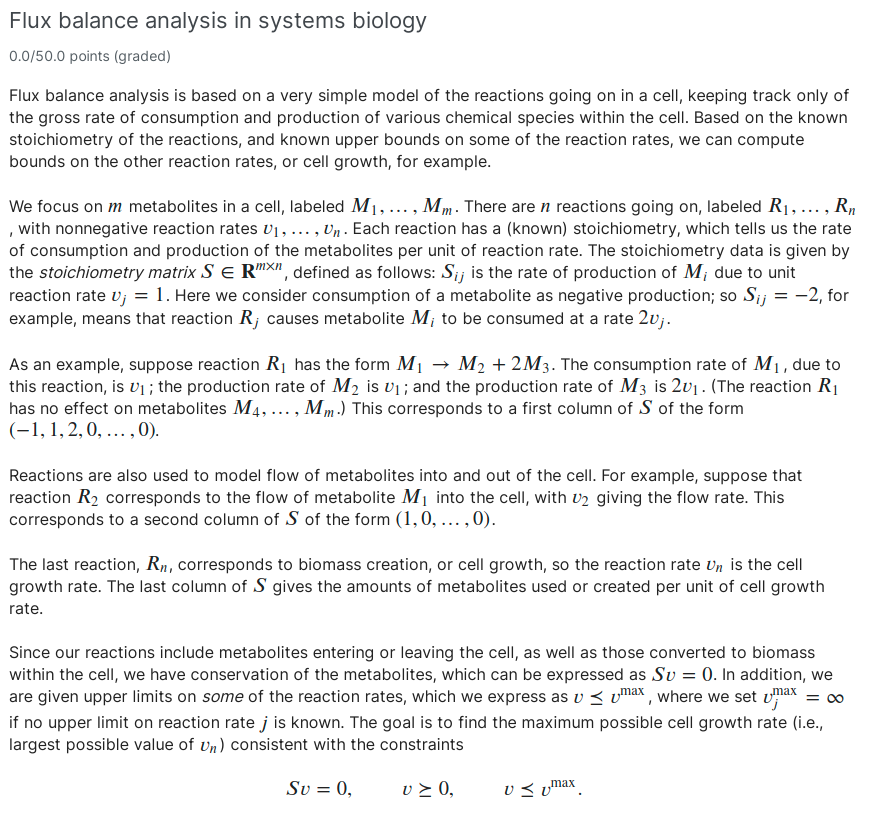

# Problem data

In [2]:
S = [
    [1,0,0,0,0,0],
    [-1,1,0,0,0,0],
    [-1,0,1,0,0,0],
    [0,-1,0,2,-1,0],
    [0,0,0,0,1,0],
    [0,-2,1,0,0,1],
    [0,0,-1,1,0,0],
    [0,0,0,0,0,-1],
    [0,0,0,-1,0,0],
]
vmax = [ 10.10, 100, 5.90, 100, 3.70, 100, 100, 100, 100]

S = np.array(S).T
vmax = np.array(vmax).reshape((-1,1))


S.shape, vmax.shape

((6, 9), (9, 1))

# Solving

In [3]:
m,n = S.shape

v = cp.Variable((n,1), name = 'v', nonneg = True)
obj = cp.Maximize(v[n-1])
vmax_ = cp.Parameter(vmax.shape, value = vmax.copy())

C = [
    S @ v == 0,
    v <= vmax_,
]
prob = cp.Problem(obj,C)
prob.solve()
assert prob.status == cp.OPTIMAL

In [4]:
max_growth = v[n-1,0].value
print("max growth rate:", max_growth)

max growth rate: 13.54999999695169


In [5]:
# Reactions limits with nonzero dual value => limit is tight
print(np.arange(1,n+1,1)[(prob.constraints[1].dual_value > 1e-8).ravel()])
# equivalent
np.arange(1,n+1,1)[(vmax - v.value < 1e-8).ravel()]

[1 3 5]


array([1, 3, 5])

In [6]:
# Reaction limit that affects most the objective
'R' + str(prob.constraints[1].dual_value.ravel().argmax() + 1)

'R5'

## Essetial Genes

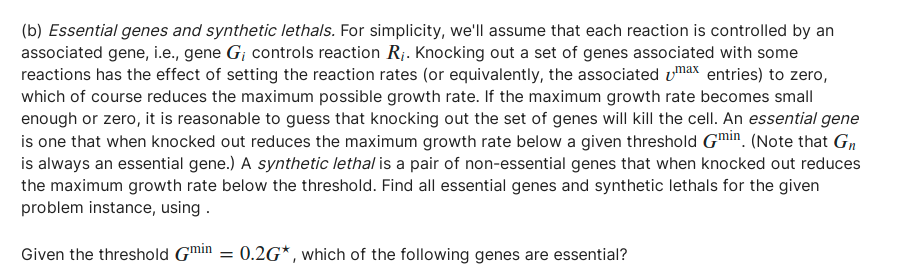

In [13]:
essential = set()
lb = 0.2 * max_growth
print('lb = ',lb)
vmax_.value = vmax.copy()

for i in range(n):
    aux = vmax_.value[i,0]
    vmax_.value[i,0] = 0
    prob.solve()
    assert prob.status == cp.OPTIMAL
    if v[n-1,0].value < lb:
        essential.add(i)
    vmax_.value[i,0] = aux
    
synthetic_letal = set()
for i in range(n):
    if i in essential: continue
    for j in range(i+1,n):
        if j in essential: continue
        a1 = vmax_.value[i,0]
        a2 = vmax_.value[j,0]
        vmax_.value[i,0] = 0
        vmax_.value[j,0] = 0
        prob.solve()
        assert prob.status == cp.OPTIMAL
        if v[n-1,0].value < lb:
            synthetic_letal.add((i,j))
        vmax_.value[i,0] = a1
        vmax_.value[j,0] = a2
            
        
    
print('essential:', np.array(list(essential))+1)
print('synthetic letal:\n', np.array(list(synthetic_letal))+1)


lb =  2.7099999993903383
essential: [1 9]
synthetic letal:
 [[2 3]
 [2 7]
 [5 7]
 [4 7]]
